In [14]:
import cv2
import dlib
import matplotlib.pyplot as plt

In [15]:
# Initialize the face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('predictor/shape_predictor_68_face_landmarks.dat')

In [16]:
# Load the image
image = cv2.imread('images/vermeer.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

[(463, 701) (998, 1236)]


Text(0.5, 1.0, 'Detected Face')

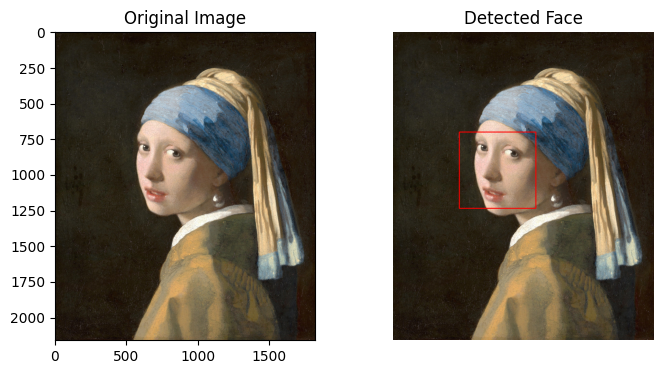

In [32]:
# Detect faces in the image
faces = detector(gray)
print(faces[0])

image_face = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
cv2.rectangle(
    image_face, 
    (faces[0].left(), faces[0].top()), 
    (faces[0].right(), faces[0].bottom()), 
    (255, 0, 0), 
    5
)

plt.close() # Clear cropping plot buffer
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plt.axis('off')  # Turn off the axis

axes[0].imshow(cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')

axes[1].imshow(image_face)
axes[1].set_title('Detected Face')

In [68]:
# Loop through each face detected
image_landmark = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

for face in faces:
    # Get the landmarks/parts for the face
    landmarks = predictor(gray, face)
    
    # Draw the landmarks with circles
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        cv2.circle(image_landmark, (x, y), 5, (255, 0, 0), -1)
        # print(x, y)

# Creating mesh

image_mesh = image_landmark.copy()

# Facial landmark indices for different parts of the face
jawline_points = list(range(0, 17))
right_eyebrow_points = list(range(17, 22))
left_eyebrow_points = list(range(22, 27))
nose_bridge_points = list(range(27, 31))
lower_nose_points = list(range(30, 36))
right_eye_points = list(range(36, 42))
left_eye_points = list(range(42, 48))
outer_lip_points = list(range(48, 60))
inner_lip_points = list(range(60, 68))

# Groups of landmarks for each facial feature
facial_feature_points = [jawline_points, right_eyebrow_points, left_eyebrow_points, 
                         nose_bridge_points, lower_nose_points, right_eye_points, 
                         left_eye_points, outer_lip_points, inner_lip_points]

# Draw the facial feature lines
for face_feature in facial_feature_points:
    for i in range(len(face_feature) - 1):
        pt1 = (landmarks.part(face_feature[i]).x, landmarks.part(face_feature[i]).y)
        pt2 = (landmarks.part(face_feature[i + 1]).x, landmarks.part(face_feature[i + 1]).y)
        cv2.line(image_mesh, pt1, pt2, (0, 255, 0), 3)

# # Connect the right eye points
# cv2.line(image_mesh, 
#          (landmarks.part(right_eye_points[0]).x, landmarks.part(right_eye_points[0]).y), 
#          (landmarks.part(right_eye_points[-1]).x, landmarks.part(right_eye_points[-1]).y), 
#          (0, 255, 0), 3)

# # Connect the left eye points
# cv2.line(image_mesh, 
#          (landmarks.part(left_eye_points[0]).x, landmarks.part(left_eye_points[0]).y), 
#          (landmarks.part(left_eye_points[-1]).x, landmarks.part(left_eye_points[-1]).y), 
#          (0, 255, 0), 3)

# # Connect the outer lip points
# cv2.line(image_mesh, 
#          (landmarks.part(outer_lip_points[0]).x, landmarks.part(outer_lip_points[0]).y), 
#          (landmarks.part(outer_lip_points[-1]).x, landmarks.part(outer_lip_points[-1]).y), 
#          (0, 255, 0), 3)

# # Connect the inner lip points
# cv2.line(image_mesh, 
#          (landmarks.part(inner_lip_points[0]).x, landmarks.part(inner_lip_points[0]).y), 
#          (landmarks.part(inner_lip_points[-1]).x, landmarks.part(inner_lip_points[-1]).y), 
#          (0, 255, 0), 3)

Text(0.5, 1.0, 'Detected face with landmarks')

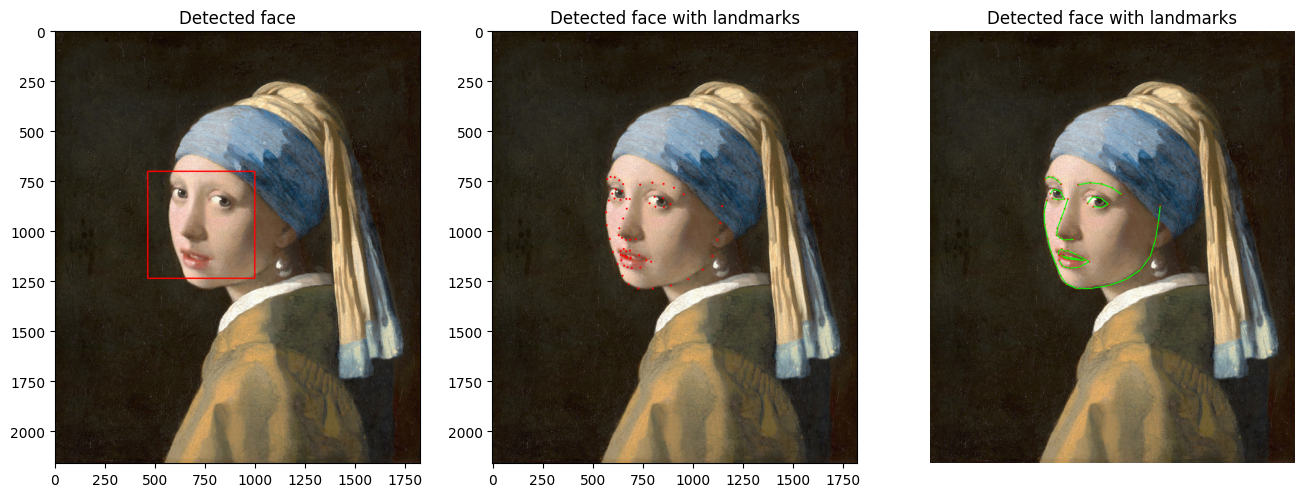

In [69]:
plt.close() # Clear cropping plot buffer
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

plt.axis('off')  # Turn off the axis

axes[0].imshow(image_face)
axes[0].set_title('Detected face')

axes[1].imshow(image_landmark)
axes[1].set_title('Detected face with landmarks')

axes[2].imshow(image_mesh)
axes[2].set_title('Detected face with landmarks')